In [3]:
### Load PPS model
%run ./PPS_Expansion_Model.ipynb

/Users/renatoparedes/.virtualenvs/pps/lib/python3.13/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [11]:
## Experiment function


def experiment_explore(
    ts, T, dist, ya, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, FWpr, CMpr
):
    """Run a PPS-assessment simulation using the following parameters
    Input:
        ts (int): the discretising timestep of the Euler integration
        T (int): the total simulation runtime
        tau (int): time constant
        dist (1D.np.array): vector of distance
        ya (int): location on the y-axis of the auditory stimulus

        Lt (4D.np.array): A matrix of shape (MxN) in which every ij position is another matrix of shape (MxN),
                          in which every hk position details the lateral connectivity of ij with hk for the tactile region
        La (4D.np.array): A matrix of shape (MxN) in which every ij position is another matrix of shape (MxN),
                          in which every hk position details the lateral connectivity of ij with hk for the auditory region
        Lv (4D.np.array): A matrix of shape (MxN) in which every ij position is another matrix of shape (MxN),
                          in which every hk position details the lateral connectivity of ij with hk for the visual region

        Wt (2D np.array): Feedforward synaptic weights in the tactile area.
        Wa (2D np.array): Feedforward synaptic weights in the auditory area.
        Wv (2D np.array): Feedforward synaptic weights in the visual area.

        Bt (2D np.array): Feedback synaptic weights in the tactile area.
        Ba (2D np.array): Feedback synaptic weights in the auditory area.
        Bv (2D np.array): Feedback synaptic weights in the visual area

        Wat (4D.np.array): a MxN matrix of auditory neurons, each containing their connections to the MxN tactile neurons (i,j,:,:); or alternatively
        a Mx N matrix of tactile neurons, each containing their connections to the MxN auditory neurons (:,:,i,j)
        Wav (4D.np.array): a MxN matrix of visual neurons, each containing their connections to the MxN auditory neurons (i,j,:,:); or alternatively
        a Mx N matrix of auditory neurons, each containing their connections to the MxN visual neurons (:,:,i,j)
        Wvt (4D.np.array): a MxN matrix of visual neurons, each containing their connections to the MxN tactile neurons (i,j,:,:); or alternatively
        a Mx N matrix of tactile neurons, each containing their connections to the MxN visual neurons (:,:,i,j)

    Output:
        zt (4D.np.array): the activation values for the tactile region for each timestep given each auditory vertical distance
        za (4D.np.array): the activation values for the auditory region for each timestep given each auditory vertical distance
        zv (4D.np.array): the activation values for the visual region for each timestep given each auditory vertical distance
        zm (2D.np.array): the activation values for the multisensory neuron for each timestep given each auditory vertical distance
        RTs (1D.np.array): the reaction times for each given distance
    """
    n = int(T / ts)  # number of iterations
    tt = ts / tau
    # Pruning of Connections

    Wa = prun(Wa, FWpr)
    Wv = prun(Wv, FWpr)

    Wat = prun(Wat, CMpr)
    Wvt = prun(Wvt, CMpr)
    Wav = prun(Wav, CMpr)

    ti = PHI_expt("t", xt / 2, yt / 2)  # tactile stimuluis

    qt = np.zeros((Mt, Nt, len(dist), n))
    ut = np.zeros((Mt, Nt, len(dist), n))
    zt = np.zeros((Mt, Nt, len(dist), n))

    qa = np.zeros((Ma, Na, len(dist), n))
    ua = np.zeros((Ma, Na, len(dist), n))
    za = np.zeros((Ma, Na, len(dist), n))

    qv = np.zeros((Mv, Nv, len(dist), n))
    uv = np.zeros((Mv, Nv, len(dist), n))
    zv = np.zeros((Mv, Nv, len(dist), n))

    qm = np.zeros((len(dist), n))
    um = np.zeros((len(dist), n))
    zm = np.zeros((len(dist), n))

    rt = np.zeros((len(dist), n))
    RTs = np.zeros(len(dist))

    for i in range(len(dist)):
        ai = PHI_expa("a", dist[i], ya)  # auditory stimulus
        for j in range(1, n):
            (
                psit,
                psia,
                psiv,
                psim,
                LT,
                LA,
                LV,
                AT,
                AV,
                TA,
                TV,
                VT,
                VA,
                BT,
                BA,
                BV,
            ) = neural(
                qt[:, :, i, j - 1],
                qa[:, :, i, j - 1],
                qv[:, :, i, j - 1],
                qm[i, j - 1],
                Lt,
                La,
                Lv,
                zt[:, :, i, j - 1],
                za[:, :, i, j - 1],
                zv[:, :, i, j - 1],
                Wat,
                Wvt,
                Wav,
                zm[i, j - 1],
                Bt,
                Ba,
                Bv,
            )

            ut[:, :, i, j] = ti + LT + BT + AT + VT
            qt[:, :, i, j] = qt[:, :, i, j - 1] + tt * (
                -qt[:, :, i, j - 1] + ut[:, :, i, j - 1]
            )
            zt[:, :, i, j] = np.maximum(psit, 0)  # heaviside function

            ua[:, :, i, j] = ai + LA + BA + TA + VA
            qa[:, :, i, j] = qa[:, :, i, j - 1] + tt * (
                -qa[:, :, i, j - 1] + ua[:, :, i, j - 1]
            )
            za[:, :, i, j] = np.maximum(psia, 0)  # heaviside function

            uv[:, :, i, j] = LV + BV + TV + AV
            qv[:, :, i, j] = qv[:, :, i, j - 1] + tt * (
                -qv[:, :, i, j - 1] + uv[:, :, i, j - 1]
            )
            zv[:, :, i, j] = np.maximum(psiv, 0)  # heaviside function

            um[i, j] = (
                np.einsum("ij, ij -> ", Wt, zt[:, :, i, j - 1])
                + np.einsum("ij, ij -> ", Wa, za[:, :, i, j - 1])
                + np.einsum("ij, ij -> ", Wv, zv[:, :, i, j - 1])
            )
            qm[i, j] = qm[i, j - 1] + tt * (-qm[i, j - 1] + um[i, j - 1])
            zm[i, j] = np.maximum(psim, 0)  # heaviside function

            rt[i, j] = np.any(zt[:, :, i, j - 1] > (0.9))

        # Compute the RT for this distance

        RTs[i] = np.argmax(rt[i, :]) * ts  # * 3 + 60

    return ut, ua, um, uv, RTs

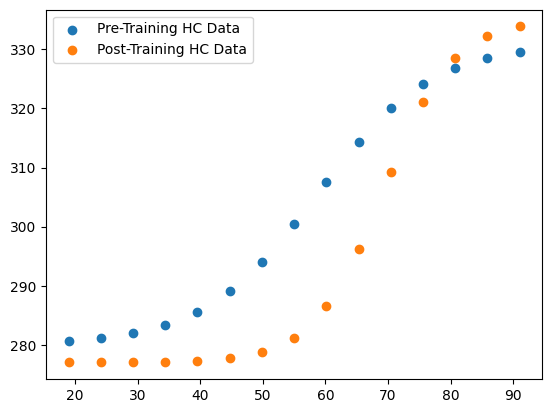

In [4]:
# Distance points in cm (network coordinates)
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 15)
v = 30  # cm/s
mydistances = 100 - ts * v  # distance points in cm (network coordinates)

ts = 0.4
simtime = 200

##Pre-Training
###Healthy Controls
ymin = 280
ymax = 331
fprHCCP = 100 - 1.377 * v
fprHCS = 1 / 0.11  # negative

HC_RTs = RTsig(mydistances, fprHCCP, fprHCS)
plt.scatter(mydistances, HC_RTs, label="Pre-Training HC Data")

##Post-Training
###Healthy Controls
ymin = 277
ymax = 335
fpostHCCP = 100 - 1.028 * v
fpostHCS = 1 / 0.18  # negative

HC_RTs_post = RTsig(mydistances, fpostHCCP, fpostHCS)
plt.scatter(mydistances, HC_RTs_post, label="Post-Training HC Data")
plt.legend()

In [12]:
## Fitted model
k_a = 5e-05
k_v = 5e-05
stim_counts = 10

rho_0, siagav_x, locav_x = 7.533e-03, 5.394e00, 3.271e01

HCLt, HCLa, HCLv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

HCWa_tr, HCWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    siagav_x,
    locav_x,
)


hc_qt, hc_qa, hc_qm, hc_qv, HC_Model_RTs_post = experiment_explore(
    ts,
    simtime,
    mydistances,
    5,
    HCLt,
    HCLa,
    HCLv,
    HCWt,
    HCWa_tr[:, :, -1, -1],
    HCWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

In [33]:
## Fitted model

Lex, Pr = 1.963e00, 1.044e-01
rho_0 = 6.159e-05
sigav_x, locav_x = 5.394e00, 3.271e01

SCZLt, SCZLa, SCZLv = Lw(Lex, 0.05, 1, 4, Lex, 0.05, 20, 80, Lex, 0.05, 2, 8)
HCWat, HCWvt, HCWav = crossmodal(0.05, 2, 0.05, 2, 0.05, 2)
HCWt, HCWa, HCWv, HCBt, HCBa, HCBv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.083e01, 5.076e02, 3.226e01, 9.968e-01
)

SCZWa_tr, SCZWv_tr, _, _, _, _ = FWTraining(
    stim_counts,
    simtime,
    ts,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    HCWa,
    HCWv,
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    Pr,
    rho_0,
    6.5,
    6.5,
    k_a,
    k_v,
    0.05,
    sigav_x,
    locav_x,
)


scz_qt, scz_qa, scz_qm, scz_qv, SCZ_Model_RTs_post = experiment_explore(
    ts,
    simtime,
    mydistances,
    5,
    SCZLt,
    SCZLa,
    SCZLv,
    HCWt,
    SCZWa_tr[:, :, -1, -1],
    SCZWv_tr[:, :, -1, -1],
    HCBt,
    HCBa,
    HCBv,
    HCWat,
    HCWvt,
    HCWav,
    0,
    0,
)

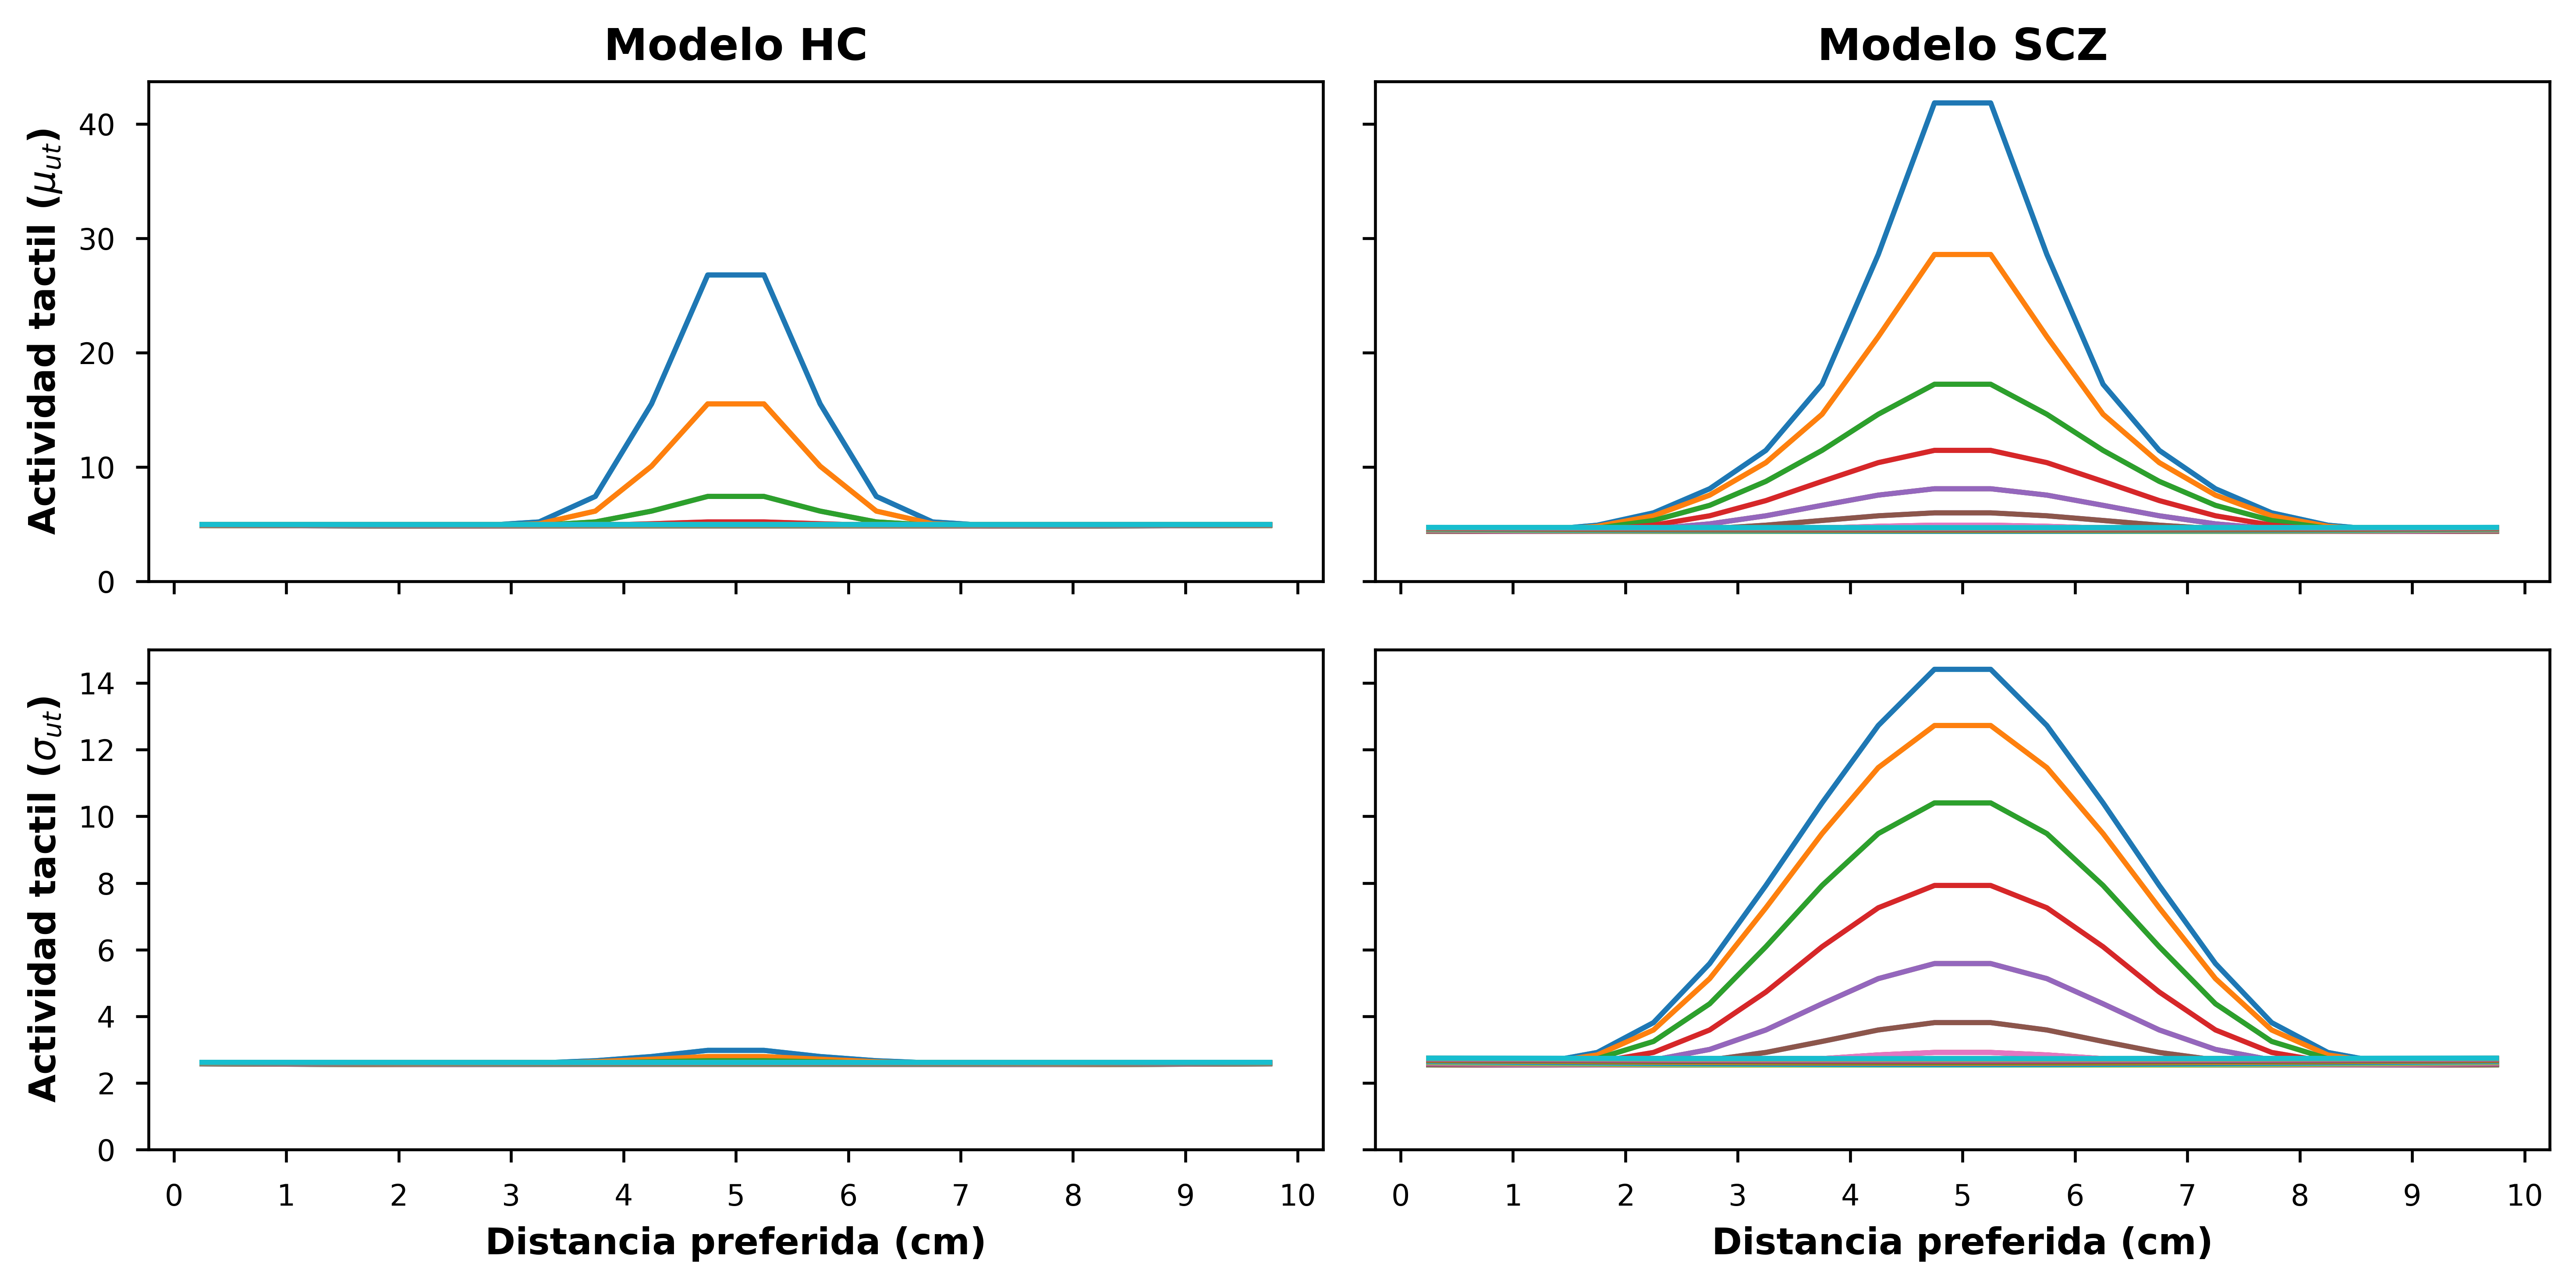

In [42]:
import string

plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qt[:, :, 7, :], axis=2).T)
ax1.set_ylabel(r"Actividad tactil ($\mu_{ut}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 20.5, 2))
ax1.set_xticklabels(np.arange(0, 11, 1))

ax2 = plt.subplot(222)
ax2.plot(np.mean(scz_qt[:, :, 7, :], axis=2).T)
ax2.set_title("Modelo SCZ", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qt[:, :, 7, :], axis=2).T)
ax3.set_ylabel(r"Actividad tactil ($\sigma_{ut}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(scz_qt[:, :, 7, :], axis=2).T)
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("drafts/FIG_Extra_1.eps", bbox_inches="tight", format="eps")
fig.savefig("drafts/FIG_Extra_1.png", bbox_inches="tight")

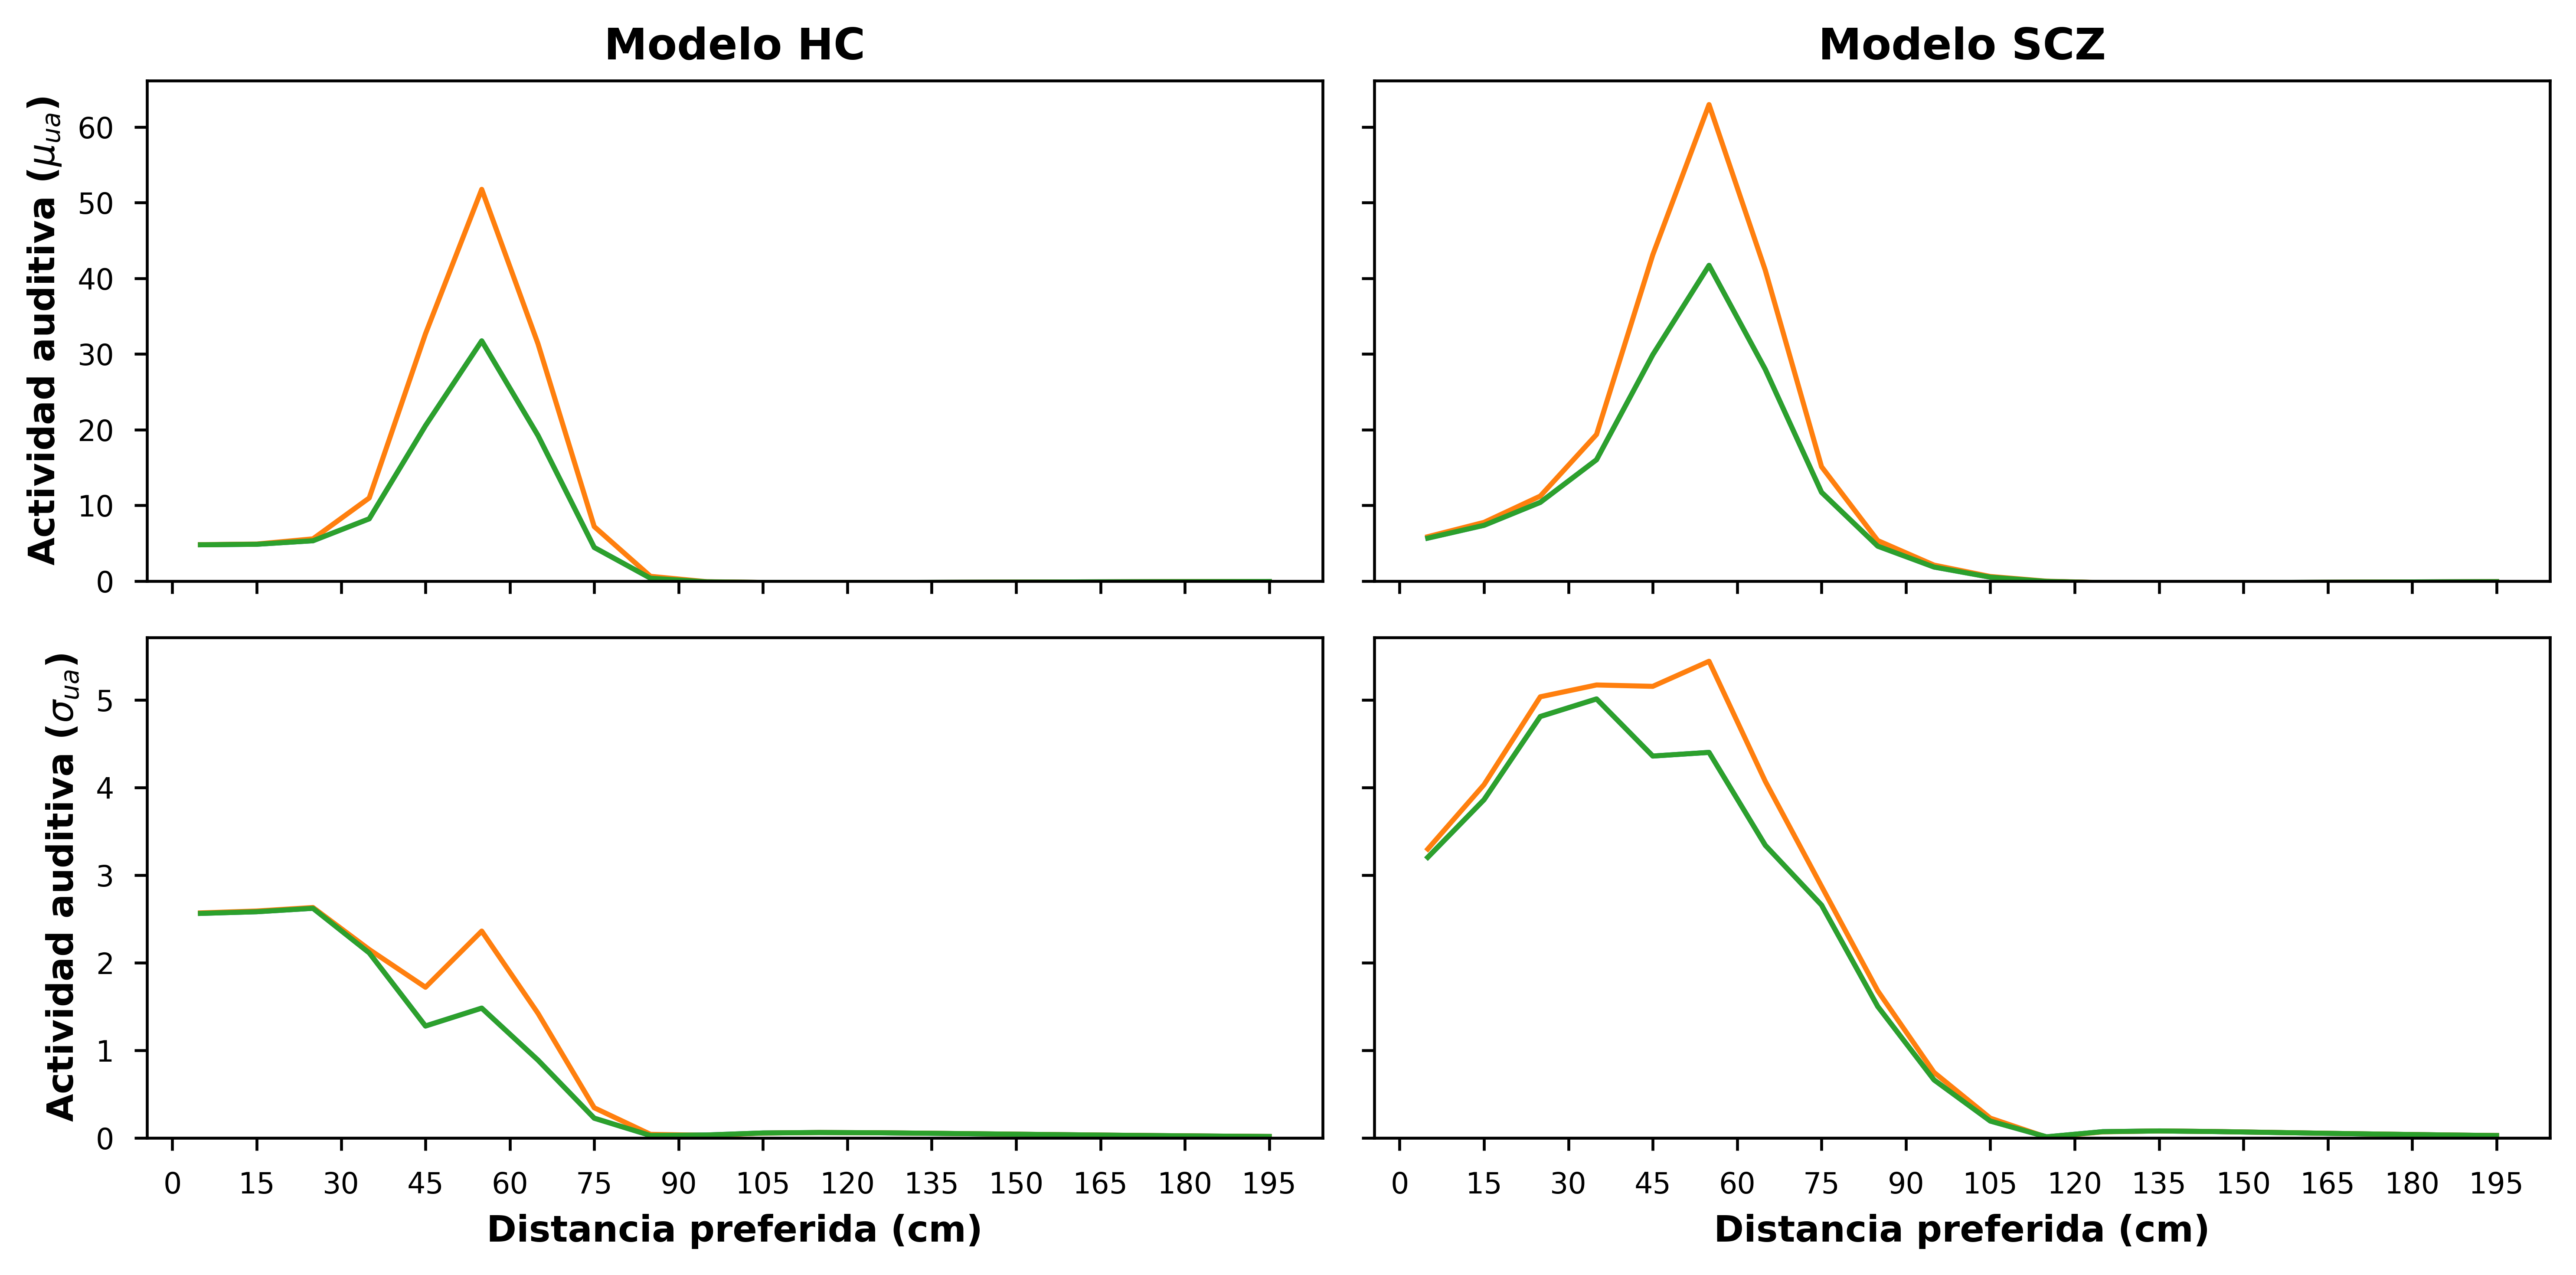

In [45]:
plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qa[:, :, 7, :], axis=2))
ax1.set_ylabel(r"Actividad auditiva ($\mu_{ua}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 19.5, 1.5))
ax1.set_xticklabels(np.arange(0, 200, 15))

ax2 = plt.subplot(222)
ax2.plot(np.mean(scz_qa[:, :, 7, :], axis=2))
ax2.set_title("Modelo SCZ", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qa[:, :, 7, :], axis=2))
ax3.set_ylabel(r"Actividad auditiva ($\sigma_{ua}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(scz_qa[:, :, 7, :], axis=2))
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("drafts/FIG_Extra_2.eps", bbox_inches="tight", format="eps")
fig.savefig("drafts/FIG_Extra_2.png", bbox_inches="tight")